# Analiza rynku nieruchomości w Polsce

In [1]:
!pip3 install pandas numpy matplotlib seaborn plotly scikit-learn openpyxl
!pip3 install "statsmodels==0.14.4" "scipy==1.15.3" yfinance fredapi
!pip3 install --upgrade nbformat


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Komórka 2: Import bibliotek i konfiguracja
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Biblioteki do analizy statystycznej
from scipy import stats
from scipy.stats import pearsonr, spearmanr, normaltest
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Biblioteki machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Konfiguracja wyświetlania
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Wszystkie biblioteki zostały załadowane pomyślnie!")


✅ Wszystkie biblioteki zostały załadowane pomyślnie!


In [3]:
from LoadData.LoadNbpData import load_nbp_data

primary_offer, primary_trans, secondary_offer, secondary_trans = load_nbp_data()
print("✅ Dane z NBP zostały załadowane pomyślnie!")
#print(primary_offer.head())
miasta = primary_offer.columns[1:].tolist()

✅ Dane z NBP zostały załadowane pomyślnie!


In [4]:
from LoadData.LoadInflation import load_inflation_data

df_inflacja_raw = load_inflation_data()
print("✅ Dane o inflacji zostały załadowane pomyślnie!")

#print(df_inflacja.head())

✅ Dane o inflacji zostały załadowane pomyślnie!


In [5]:
from LoadData.LoadWibor import load_wibor

df_wibor = load_wibor()
print("✅ Dane WIBOR zostały załadowane pomyślnie!")

#print(df_wibor.head())

✅ Dane WIBOR zostały załadowane pomyślnie!


## Komórka 4: Czyszczenie i feature engineering danych


In [6]:
from DataProcessing.Preprocess import dodaj_kolumny_daty, polacz_dataframes

print("📅 Przetwarzanie dat i tworzenie zmiennych czasowych...")

primary_offer = dodaj_kolumny_daty(primary_offer)
secondary_offer = dodaj_kolumny_daty(secondary_offer)
primary_trans = dodaj_kolumny_daty(primary_trans)
secondary_trans = dodaj_kolumny_daty(secondary_trans)

df_inflacja = dodaj_kolumny_daty(df_inflacja_raw)[['CPI_Y2Y', 'CPI_Q2Q', 'Data']]
df_inflacja['CPI_Y2Y'] = df_inflacja['CPI_Y2Y'] - 100
df_inflacja['CPI_Q2Q'] = df_inflacja['CPI_Q2Q'] - 100
primary_offer = dodaj_kolumny_daty(primary_offer)
secondary_offer = dodaj_kolumny_daty(secondary_offer)
primary_trans = dodaj_kolumny_daty(primary_trans)
secondary_trans = dodaj_kolumny_daty(secondary_trans)
#print(df_inflacja.head())

📅 Przetwarzanie dat i tworzenie zmiennych czasowych...


### Merge dataframes

In [7]:

rynek_pierwotny_ofertowe = polacz_dataframes(primary_offer, df_inflacja, df_wibor, on_col='Data')
rynek_pierwotny_transakcyjne = polacz_dataframes(primary_trans, df_inflacja, df_wibor, on_col='Data')
rynek_wtorny_ofertowe = polacz_dataframes(secondary_offer, df_inflacja, df_wibor, on_col='Data')
rynek_wtorny_transakcyjne = polacz_dataframes(secondary_trans, df_inflacja, df_wibor, on_col='Data')
#print(rynek_wtorny_transakcyjne.head())

## Komórka 5: Analiza statystyczna dla danych w nowym formacie


In [8]:
# Komórka 5a: Przygotowanie danych do analiz korelacyjnych

def przeksztalc_dane_do_formatu_dlugiego(rynek_pierwotny_ofertowe, rynek_pierwotny_transakcyjne, 
                                         rynek_wtorny_ofertowe, rynek_wtorny_transakcyjne):
    """
    Przekształca cztery dataframes w format długi dla łatwiejszej analizy
    """
    print("🔄 Przekształcanie danych do formatu dogodnego dla analizy korelacji...")
    
    # Interesujące nas miasta
    miasta_do_analizy = ['Białystok', 'Bydgoszcz', 'Gdańsk', 'Gdynia', 'Katowice', 'Kielce', 'Kraków', 'Lublin',
        'Łódź', 'Olsztyn', 'Opole', 'Poznań', 'Rzeszów', 'Szczecin', 'Warszawa', 'Wrocław', 'Zielona Góra']
    
    # Obliczenie średnich cen dla wszystkich miast
    df_pierwotny_ofertowe = rynek_pierwotny_ofertowe.copy()
    df_pierwotny_transakcyjne = rynek_pierwotny_transakcyjne.copy()
    df_wtorny_ofertowe = rynek_wtorny_ofertowe.copy()
    df_wtorny_transakcyjne = rynek_wtorny_transakcyjne.copy()
    
    # Dodanie średnich po miastach
    for df in [df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne]:
        miasta_cols = [col for col in df.columns if col in miasta_do_analizy]
        df['średnia_miast'] = df[miasta_cols].mean(axis=1)
    
    # Obliczenie rocznych zmian cen (rok do roku)
    for df in [df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne]:
        for miasto in miasta_do_analizy + ['średnia_miast']:
            if miasto in df.columns:
                df[f'{miasto}_roczna_zmiana'] = df[miasto].pct_change(4) * 100  # 4 kwartały

    print("✅ Dane zostały przekształcone pomyślnie")
    return df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne

# Wywołanie funkcji
df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne = \
    przeksztalc_dane_do_formatu_dlugiego(rynek_pierwotny_ofertowe, rynek_pierwotny_transakcyjne, 
                                          rynek_wtorny_ofertowe, rynek_wtorny_transakcyjne)


🔄 Przekształcanie danych do formatu dogodnego dla analizy korelacji...
✅ Dane zostały przekształcone pomyślnie


🔍 Analiza korelacji cen między wybranymi miastami...


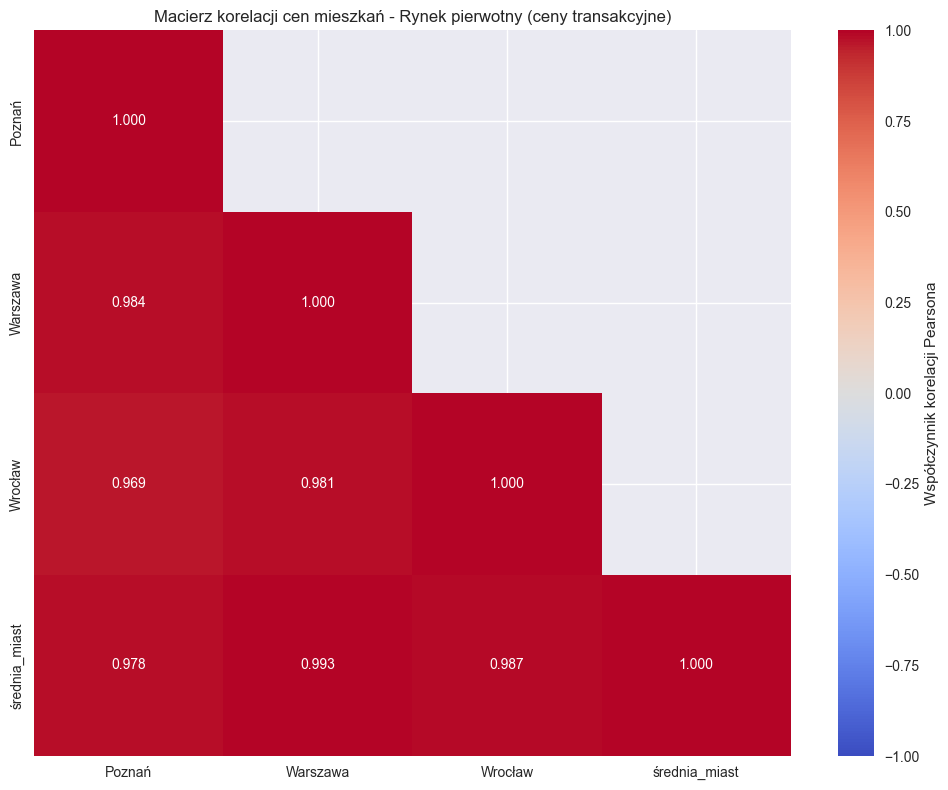

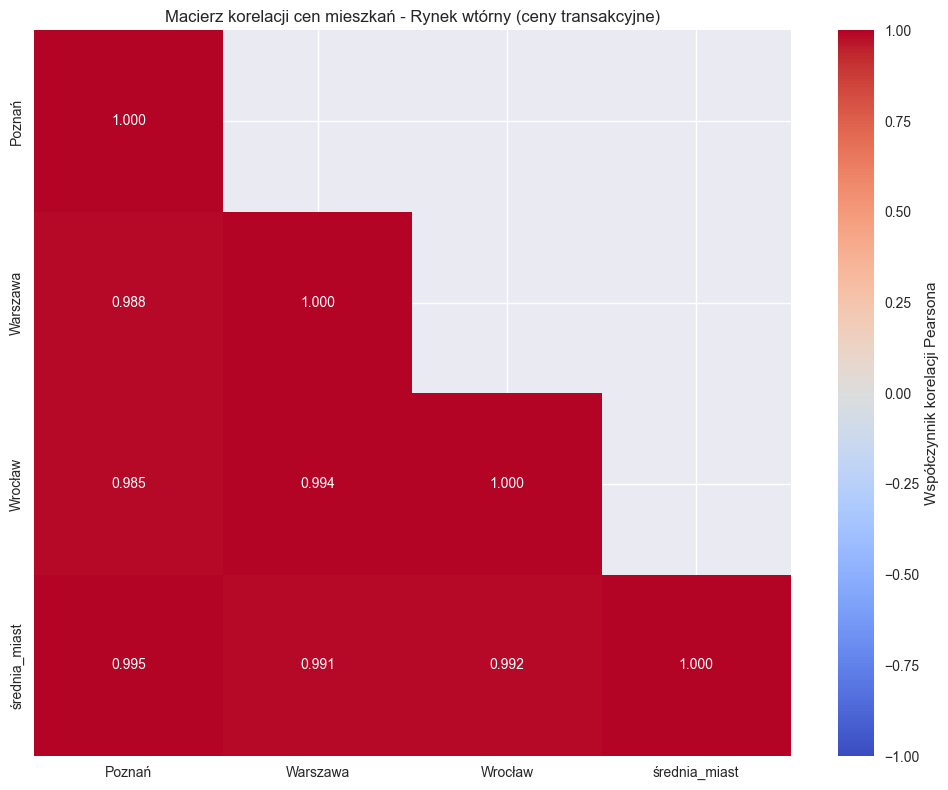


📊 Szczegółowe wyniki korelacji dla rynku pierwotnego (ceny transakcyjne):
Warszawa vs Poznań: r = 0.984, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
Wrocław vs Poznań: r = 0.969, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
Wrocław vs Warszawa: r = 0.981, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
średnia_miast vs Poznań: r = 0.978, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
średnia_miast vs Warszawa: r = 0.993, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
średnia_miast vs Wrocław: r = 0.987, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)

📊 Szczegółowe wyniki korelacji dla rynku wtórnego (ceny transakcyjne):
Warszawa vs Poznań: r = 0.988, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
Wrocław vs Poznań: r = 0.985, p-value = 0.0000
   ✓ Korelacja jest statystycznie istotna (p < 0.05)
Wrocław vs Warszawa: r = 0.9

In [9]:
# Komórka 5b: Analiza korelacji cen pomiędzy miastami

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

def korelacja_cen_miedzy_miastami(df_pierwotny_trans, df_wtorny_trans):
    """
    Analiza korelacji cen między wybranymi miastami (Poznań, Warszawa, Wrocław)
    Wyświetla dolną połówkę macierzy korelacji bez diagonali
    """
    print("🔍 Analiza korelacji cen między wybranymi miastami...")
    
    # Wybór miast do analizy
    miasta_do_korelacji = ['Poznań', 'Warszawa', 'Wrocław', 'średnia_miast']
    
    # Tworzenie dataframe z cenami wybranych miast
    df_pierwotny_miasta = df_pierwotny_trans[miasta_do_korelacji].copy()
    df_wtorny_miasta = df_wtorny_trans[miasta_do_korelacji].copy()
    
    # Obliczenie korelacji Pearsona
    corr_pierwotny = df_pierwotny_miasta.corr(method='pearson')
    corr_wtorny = df_wtorny_miasta.corr(method='pearson')
    
    # Tworzenie masek dla dolnej trójkątnej macierzy bez diagonali
    mask_pierwotny = np.triu(np.ones_like(corr_pierwotny), k=1)
    mask_wtorny = np.triu(np.ones_like(corr_wtorny), k=1)
    
    # Wizualizacja - rynek pierwotny
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_pierwotny, annot=True, fmt='.3f', cmap='coolwarm', 
                mask=mask_pierwotny, vmin=-1, vmax=1, cbar_kws={'label': 'Współczynnik korelacji Pearsona'})
    plt.title('Macierz korelacji cen mieszkań - Rynek pierwotny (ceny transakcyjne)')
    plt.tight_layout()
    plt.show()
    
    # Wizualizacja - rynek wtórny
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_wtorny, annot=True, fmt='.3f', cmap='coolwarm', 
                mask=mask_wtorny, vmin=-1, vmax=1, cbar_kws={'label': 'Współczynnik korelacji Pearsona'})
    plt.title('Macierz korelacji cen mieszkań - Rynek wtórny (ceny transakcyjne)')
    plt.tight_layout()
    plt.show()
    
    # Wypisanie szczegółowych wyników i testów statystycznych
    print("\n📊 Szczegółowe wyniki korelacji dla rynku pierwotnego (ceny transakcyjne):")
    for i, miasto1 in enumerate(miasta_do_korelacji):
        for j, miasto2 in enumerate(miasta_do_korelacji):
            if j < i:  # Tylko dolna część macierzy
                corr, p_value = pearsonr(df_pierwotny_miasta[miasto1].dropna().to_list(), df_pierwotny_miasta[miasto2].dropna().to_list())
                print(f"{miasto1} vs {miasto2}: r = {corr:.3f}, p-value = {p_value:.4f}")
                if p_value < 0.05:
                    print("   ✓ Korelacja jest statystycznie istotna (p < 0.05)")
                else:
                    print("   ✗ Korelacja nie jest statystycznie istotna")

    print("\n📊 Szczegółowe wyniki korelacji dla rynku wtórnego (ceny transakcyjne):")
    for i, miasto1 in enumerate(miasta_do_korelacji):
        for j, miasto2 in enumerate(miasta_do_korelacji):
            if j < i:  # Tylko dolna część macierzy
                corr, p_value = pearsonr(df_wtorny_miasta[miasto1].dropna().to_list(), df_wtorny_miasta[miasto2].dropna().to_list())
                print(f"{miasto1} vs {miasto2}: r = {corr:.3f}, p-value = {p_value:.4f}")
                if p_value < 0.05:
                    print("   ✓ Korelacja jest statystycznie istotna (p < 0.05)")
                else:
                    print("   ✗ Korelacja nie jest statystycznie istotna")

    return corr_pierwotny, corr_wtorny

# Wywołanie analizy
corr_pierwotny, corr_wtorny = korelacja_cen_miedzy_miastami(df_pierwotny_transakcyjne, df_wtorny_transakcyjne)


🔍 Analiza korelacji zmian cen mieszkań ze wskaźnikami ekonomicznymi...

📊 Wyniki korelacji zmian cen mieszkań z inflacją (CPI) i stopą WIBOR:
           miasto      rynek      typ_ceny  corr_cpi     p_cpi  corr_wibor   p_wibor  istotny_cpi  istotny_wibor
0          Poznań  pierwotny  transakcyjne  0.271416  0.022047    0.186157  0.120097         True          False
1          Poznań  pierwotny      ofertowe  0.307030  0.009204    0.130512  0.277993         True          False
2          Poznań     wtórny  transakcyjne  0.144268  0.230008    0.085232  0.479742        False          False
3          Poznań     wtórny      ofertowe  0.136398  0.256701    0.013605  0.910339        False          False
4        Warszawa  pierwotny  transakcyjne  0.183823  0.124899    0.034151  0.777381        False          False
5        Warszawa  pierwotny      ofertowe  0.222529  0.062147    0.178916  0.135467        False          False
6        Warszawa     wtórny  transakcyjne  0.166568  0.165035   -0

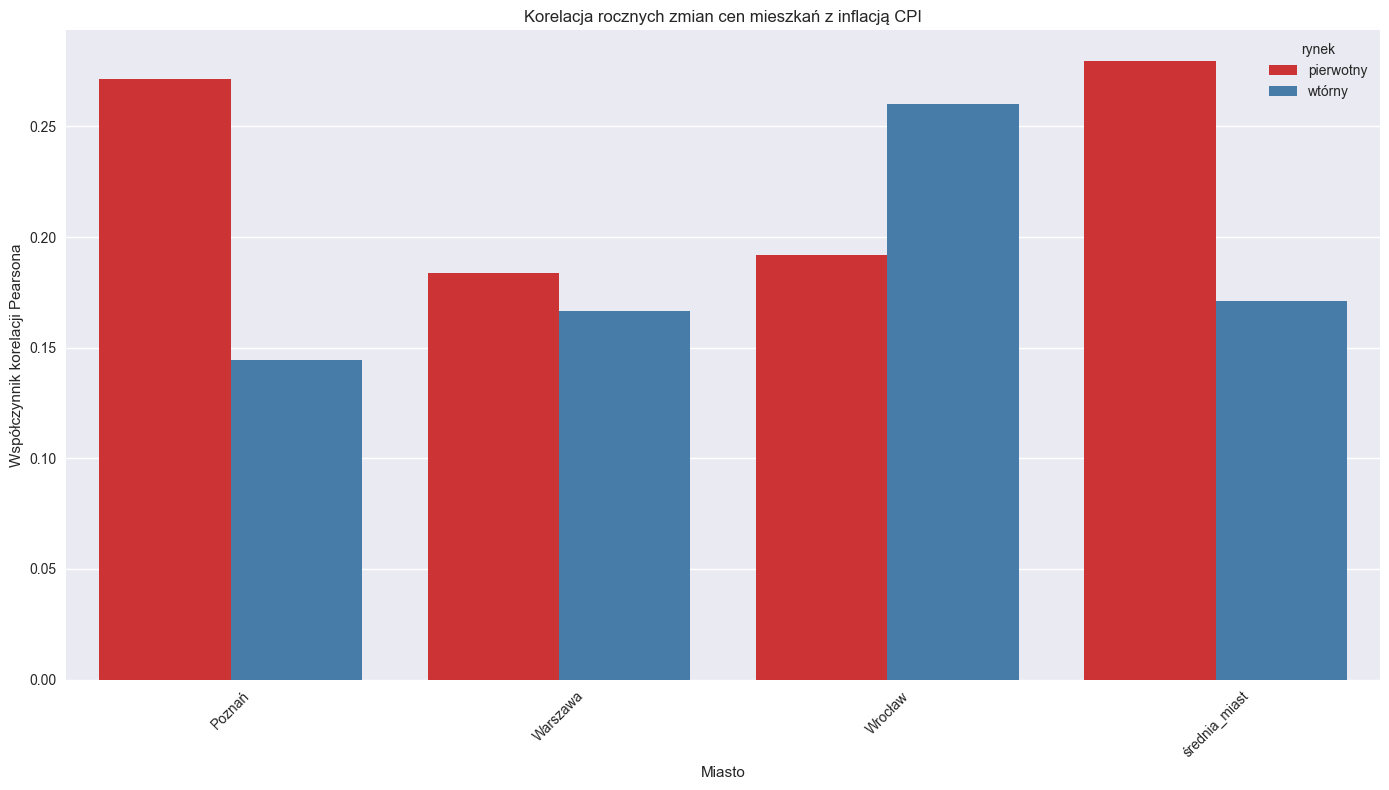

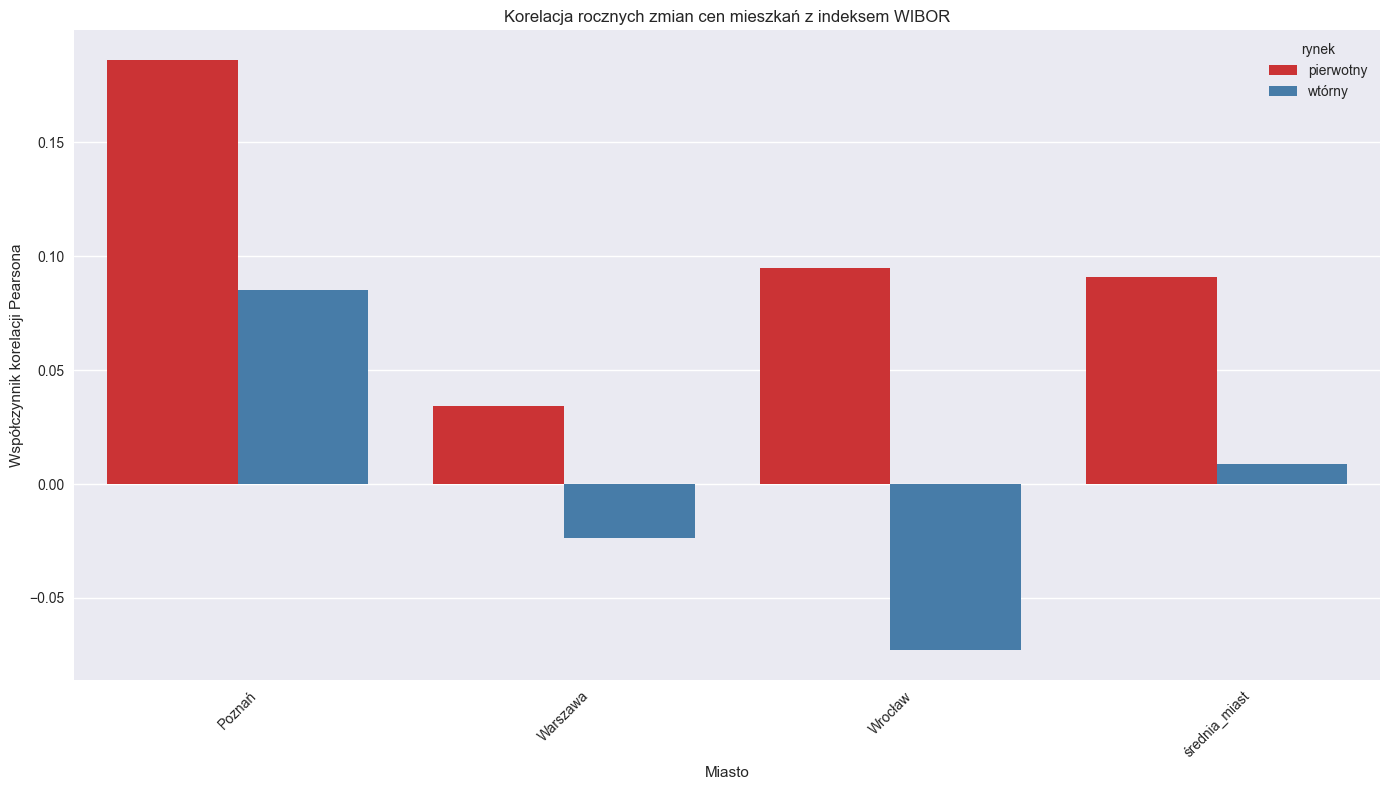

In [10]:
# Komórka 5c: Analiza korelacji zmian cen mieszkań z inflacją i WIBOR

def korelacja_z_wskaznikami_ekonomicznymi(df_pierwotny_of, df_pierwotny_tr, df_wtorny_of, df_wtorny_tr):
    """
    Bada korelacje między rocznymi zmianami cen mieszkań a inflacją i stopami WIBOR
    """
    print("🔍 Analiza korelacji zmian cen mieszkań ze wskaźnikami ekonomicznymi...")
    
    # Wybór miast do analizy
    miasta_do_korelacji = ['Poznań', 'Warszawa', 'Wrocław', 'średnia_miast']
    
    # Przygotowanie danych do analizy
    data = []
    
    # Zbieranie danych o rocznych zmianach cen dla każdego miasta i rodzaju rynku
    for miasto in miasta_do_korelacji:
        zmiana_kolumny = f'{miasto}_roczna_zmiana'
        
        # Zbieranie danych tylko gdy kolumna istnieje
        if zmiana_kolumny in df_pierwotny_tr.columns and zmiana_kolumny in df_wtorny_tr.columns:
            # Łączenie danych o zmianach cen z danymi o inflacji i WIBOR
            df_prim_tr = df_pierwotny_tr[[zmiana_kolumny, 'CPI_Y2Y', 'WIBOR']].copy().dropna()
            df_prim_of = df_pierwotny_of[[zmiana_kolumny, 'CPI_Y2Y', 'WIBOR']].copy().dropna()
            df_sec_tr = df_wtorny_tr[[zmiana_kolumny, 'CPI_Y2Y', 'WIBOR']].copy().dropna()
            df_sec_of = df_wtorny_of[[zmiana_kolumny, 'CPI_Y2Y', 'WIBOR']].copy().dropna()
            
            # Obliczanie korelacji i p-value
            for df, rynek, typ_ceny in [
                (df_prim_tr, 'pierwotny', 'transakcyjne'),
                (df_prim_of, 'pierwotny', 'ofertowe'),
                (df_sec_tr, 'wtórny', 'transakcyjne'),
                (df_sec_of, 'wtórny', 'ofertowe')
            ]:
                if not df.empty:
                    # Korelacja z inflacją
                    corr_cpi, p_cpi = pearsonr(df[zmiana_kolumny].to_list(), df['CPI_Y2Y'].to_list())
                    # Korelacja z WIBOR
                    corr_wibor, p_wibor = pearsonr(df[zmiana_kolumny].to_list(), df['WIBOR'].to_list())
                    
                    data.append({
                        'miasto': miasto,
                        'rynek': rynek,
                        'typ_ceny': typ_ceny,
                        'corr_cpi': corr_cpi,
                        'p_cpi': p_cpi,
                        'corr_wibor': corr_wibor,
                        'p_wibor': p_wibor,
                        'istotny_cpi': p_cpi < 0.05,
                        'istotny_wibor': p_wibor < 0.05
                    })
    
    # Tworzenie DataFrame z wynikami
    results_df = pd.DataFrame(data)
    
    # Wyświetlenie wyników
    print("\n📊 Wyniki korelacji zmian cen mieszkań z inflacją (CPI) i stopą WIBOR:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(results_df[['miasto', 'rynek', 'typ_ceny', 'corr_cpi', 'p_cpi', 'corr_wibor', 'p_wibor', 
                      'istotny_cpi', 'istotny_wibor']])
    
    # Wizualizacja wyników dla miast i typów rynku
    plt.figure(figsize=(14, 8))
    
    # Filtrowanie tylko transakcyjnych cen
    df_trans = results_df[results_df['typ_ceny'] == 'transakcyjne']
    
    # Tworzenie barplotów dla korelacji z CPI i WIBOR
    sns.barplot(x='miasto', y='corr_cpi', hue='rynek', data=df_trans, palette='Set1')
    plt.title('Korelacja rocznych zmian cen mieszkań z inflacją CPI')
    plt.xlabel('Miasto')
    plt.ylabel('Współczynnik korelacji Pearsona')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='miasto', y='corr_wibor', hue='rynek', data=df_trans, palette='Set1')
    plt.title('Korelacja rocznych zmian cen mieszkań z indeksem WIBOR')
    plt.xlabel('Miasto')
    plt.ylabel('Współczynnik korelacji Pearsona')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Wywołanie analizy
wyniki_korelacji = korelacja_z_wskaznikami_ekonomicznymi(
    df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne)


🔍 Analiza korelacji zmian cen między rynkiem pierwotnym a wtórnym...

📊 Korelacje zmian cen pomiędzy rynkiem pierwotnym a wtórnym:
          miasto      typ_ceny  korelacja       p_value  istotna  liczba_obserwacji
0         Poznań  transakcyjne   0.860054  7.559948e-22     True                 71
1         Poznań      ofertowe   0.872580  3.699666e-23     True                 71
2       Warszawa  transakcyjne   0.841855  3.731781e-20     True                 71
3       Warszawa      ofertowe   0.711360  3.594620e-12     True                 71
4        Wrocław  transakcyjne   0.807636  1.750380e-17     True                 71
5        Wrocław      ofertowe   0.640204  1.837119e-09     True                 71
6  średnia_miast  transakcyjne   0.962532  7.772995e-41     True                 71
7  średnia_miast      ofertowe   0.960495  4.665865e-40     True                 71


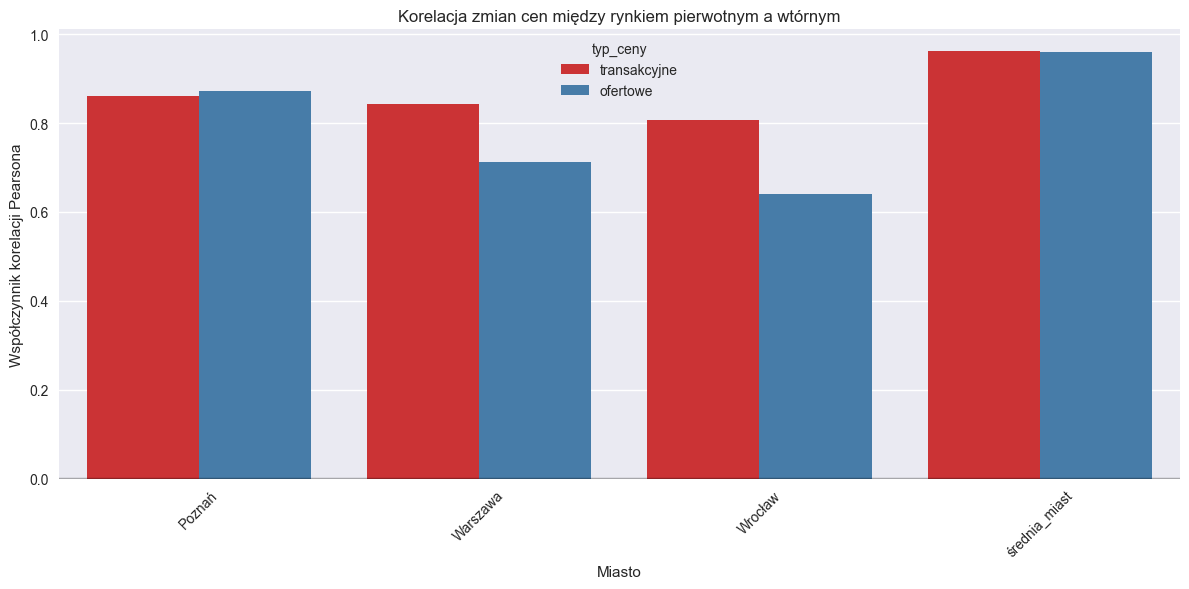

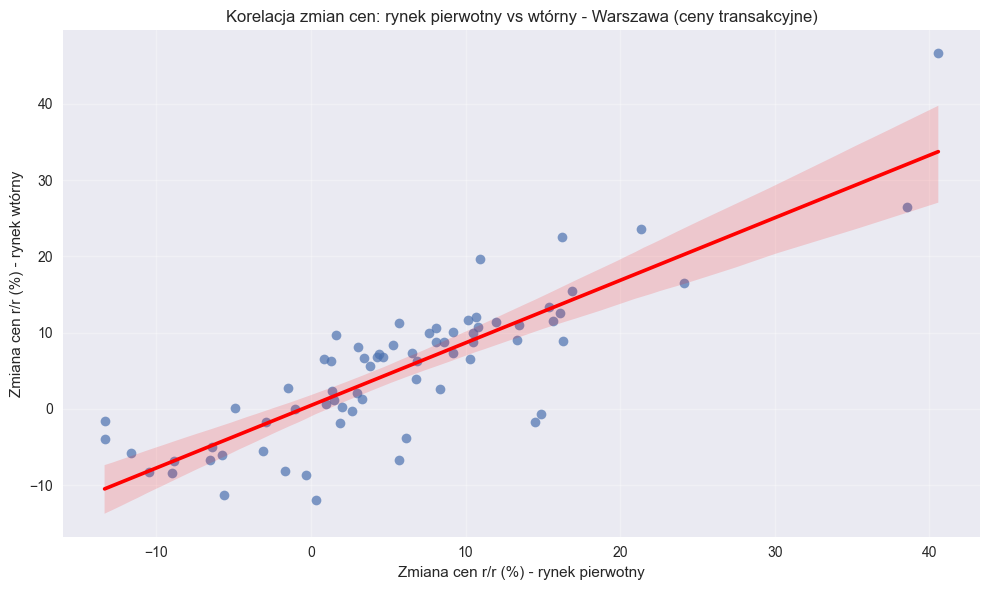

In [11]:
# Komórka 5d: Korelacja zmian cen na rynku wtórnym i pierwotnym

def korelacja_rynek_pierwotny_wtorny(df_pierwotny_of, df_pierwotny_tr, df_wtorny_of, df_wtorny_tr):
    """
    Analiza korelacji zmian cen między rynkiem pierwotnym a wtórnym
    """
    print("🔍 Analiza korelacji zmian cen między rynkiem pierwotnym a wtórnym...")
    
    # Wybór miast do analizy
    miasta_do_korelacji = ['Poznań', 'Warszawa', 'Wrocław', 'średnia_miast']
    
    # Przygotowanie danych
    wyniki = []
    
    for miasto in miasta_do_korelacji:
        zmiana_kolumna = f'{miasto}_roczna_zmiana'
        
        # Korelacja dla cen transakcyjnych
        if zmiana_kolumna in df_pierwotny_tr.columns and zmiana_kolumna in df_wtorny_tr.columns:
            # Łączenie danych z obu rynków
            df_tr = pd.merge(
                df_pierwotny_tr[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'pierwotny'}),
                df_wtorny_tr[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'wtórny'}),
                on='Data', how='inner'
            ).dropna()
            
            if len(df_tr) > 5:  # Minimum obserwacji dla wiarygodnej korelacji
                corr_tr, p_tr = pearsonr(df_tr['pierwotny'].to_list(), df_tr['wtórny'].to_list())
                
                wyniki.append({
                    'miasto': miasto,
                    'typ_ceny': 'transakcyjne',
                    'korelacja': corr_tr,
                    'p_value': p_tr,
                    'istotna': p_tr < 0.05,
                    'liczba_obserwacji': len(df_tr)
                })
        
        # Korelacja dla cen ofertowych
        if zmiana_kolumna in df_pierwotny_of.columns and zmiana_kolumna in df_wtorny_of.columns:
            # Łączenie danych z obu rynków
            df_of = pd.merge(
                df_pierwotny_of[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'pierwotny'}),
                df_wtorny_of[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'wtórny'}),
                on='Data', how='inner'
            ).dropna()
            
            if len(df_of) > 5:  # Minimum obserwacji dla wiarygodnej korelacji
                corr_of, p_of = pearsonr(df_of['pierwotny'].to_list(), df_of['wtórny'].to_list())
                
                wyniki.append({
                    'miasto': miasto,
                    'typ_ceny': 'ofertowe',
                    'korelacja': corr_of,
                    'p_value': p_of,
                    'istotna': p_of < 0.05,
                    'liczba_obserwacji': len(df_of)
                })
    
    # Tworzenie DataFrame z wynikami
    results_df = pd.DataFrame(wyniki)
    
    # Wyświetlenie wyników
    print("\n📊 Korelacje zmian cen pomiędzy rynkiem pierwotnym a wtórnym:")
    print(results_df)
    
    # Wizualizacja wyników
    plt.figure(figsize=(12, 6))
    sns.barplot(x='miasto', y='korelacja', hue='typ_ceny', data=results_df, palette='Set1')
    plt.title('Korelacja zmian cen między rynkiem pierwotnym a wtórnym')
    plt.xlabel('Miasto')
    plt.ylabel('Współczynnik korelacji Pearsona')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Scatter ploty dla wybranych miast
    for miasto in ['Warszawa']:
        zmiana_kolumna = f'{miasto}_roczna_zmiana'
        
        # Dla cen transakcyjnych
        if zmiana_kolumna in df_pierwotny_tr.columns and zmiana_kolumna in df_wtorny_tr.columns:
            df_tr = pd.merge(
                df_pierwotny_tr[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'pierwotny'}),
                df_wtorny_tr[['Data', zmiana_kolumna]].rename(columns={zmiana_kolumna: 'wtórny'}),
                on='Data', how='inner'
            ).dropna()
            
            if not df_tr.empty:
                plt.figure(figsize=(10, 6))
                sns.regplot(x='pierwotny', y='wtórny', data=df_tr, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
                plt.title(f'Korelacja zmian cen: rynek pierwotny vs wtórny - {miasto} (ceny transakcyjne)')
                plt.xlabel('Zmiana cen r/r (%) - rynek pierwotny')
                plt.ylabel('Zmiana cen r/r (%) - rynek wtórny')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
    
    return results_df

# Wywołanie analizy
wyniki_korelacji_rynkow = korelacja_rynek_pierwotny_wtorny(
    df_pierwotny_ofertowe, df_pierwotny_transakcyjne, df_wtorny_ofertowe, df_wtorny_transakcyjne)


🧪 Przeprowadzanie testów statystycznych...

📋 Wyniki testów statystycznych:
          miasto  test_t_stat  test_t_p_value  test_t_istotny  trend_pierwotny_slope  trend_pierwotny_p  trend_pierwotny_istotny  trend_wtorny_slope  trend_wtorny_p  trend_wtorny_istotny
0         Poznań     3.266157        0.001356            True              64.769840       3.940770e-15                     True           63.432874    2.705981e-17                  True
1       Warszawa    -0.588665        0.556984           False              97.928180       5.496659e-17                     True           90.071166    3.626652e-14                  True
2        Wrocław     1.035193        0.302309           False              99.044899       1.829185e-21                     True           75.751781    3.948230e-15                  True
3  średnia_miast     2.323643        0.021525            True              76.017800       2.337861e-20                     True           65.720704    1.557204e-18            

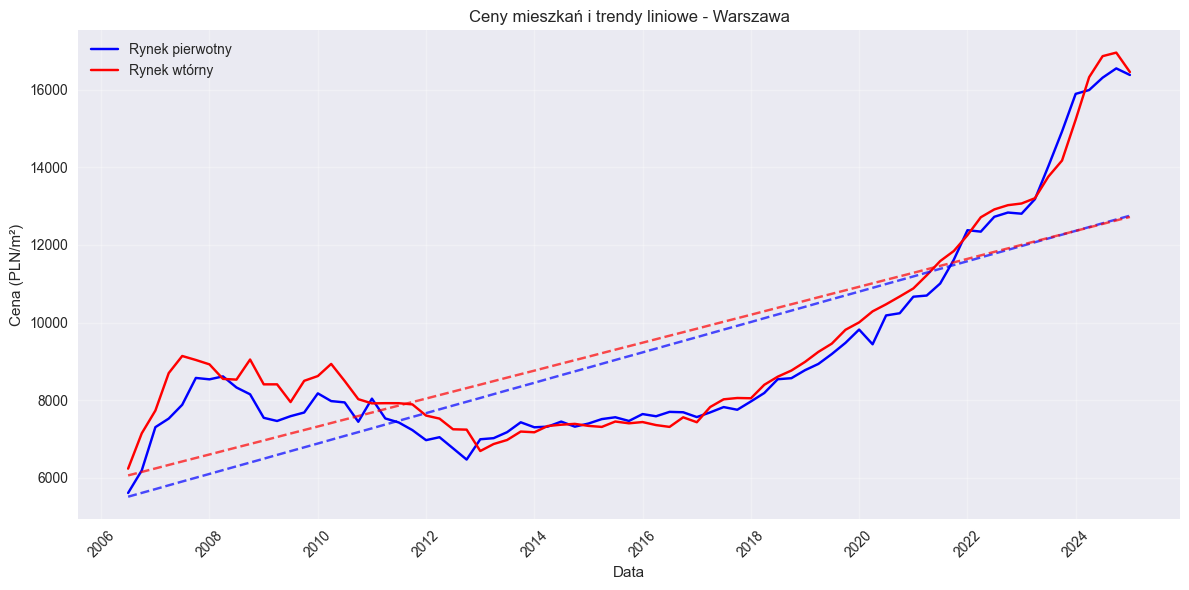

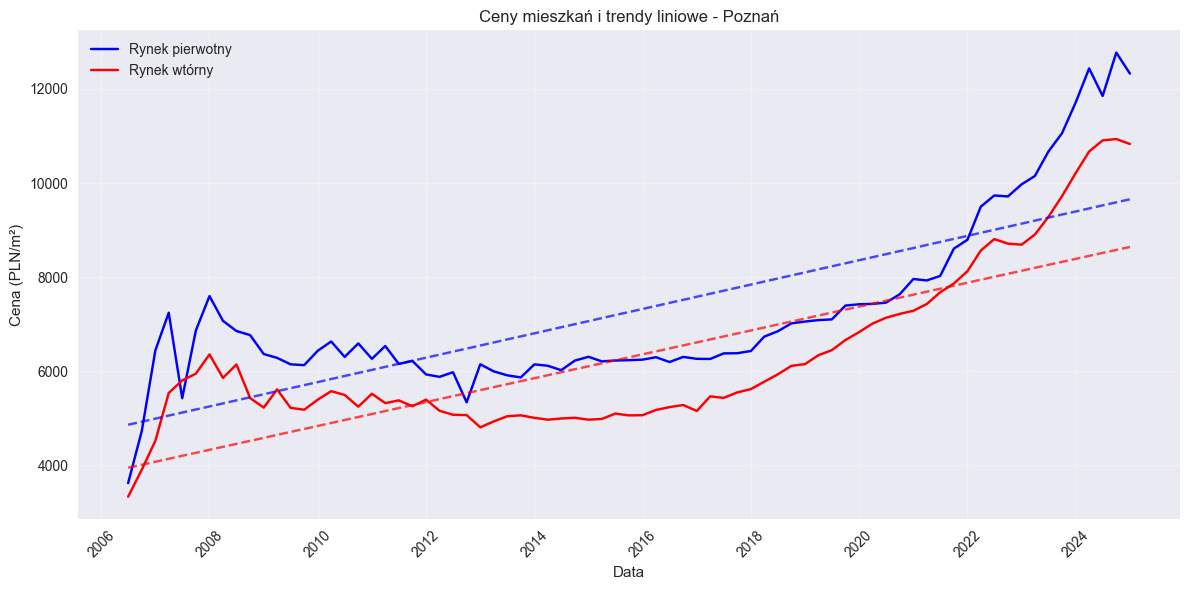

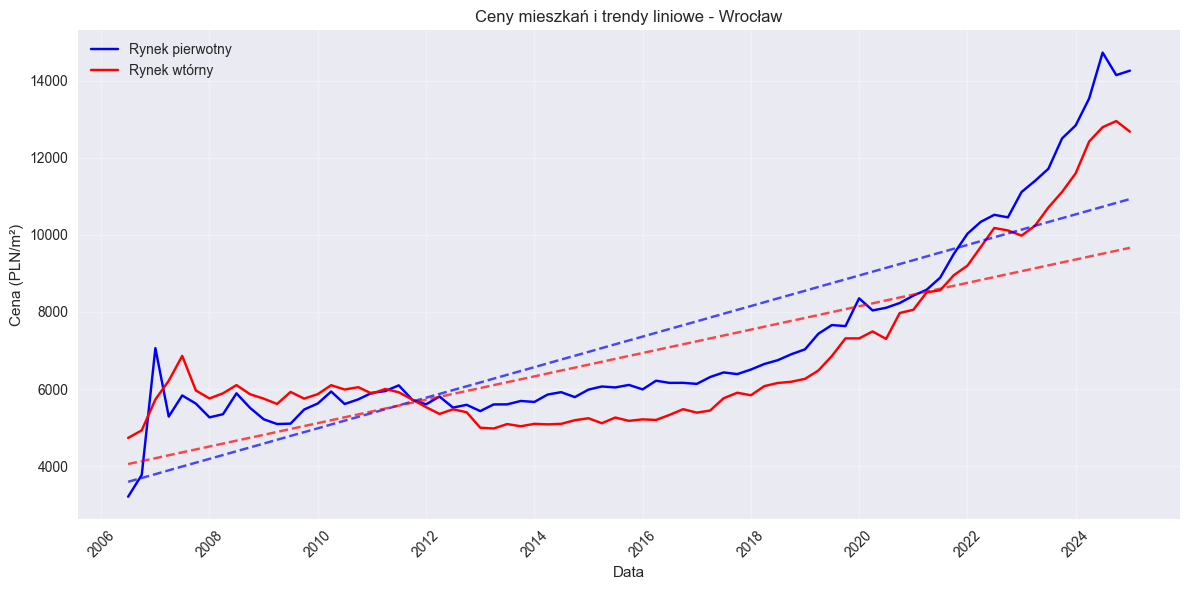

In [12]:
# Komórka 5e: Standardowe testy statystyczne

def przeprowadz_testy_statystyczne(df_pierwotny_tr, df_wtorny_tr):
    """
    Przeprowadzenie standardowych testów statystycznych dla danych cenowych
    """
    print("🧪 Przeprowadzanie testów statystycznych...")
    
    # Wybór miast do analizy
    miasta_do_testow = ['Poznań', 'Warszawa', 'Wrocław', 'średnia_miast']
    
    wyniki_testow = []
    
    for miasto in miasta_do_testow:
        # Test t dla średnich
        from scipy.stats import ttest_ind
        
        # Pobieranie danych cenowych
        if miasto in df_pierwotny_tr.columns and miasto in df_wtorny_tr.columns:
            ceny_pierwotny = df_pierwotny_tr[miasto].dropna()
            ceny_wtorny = df_wtorny_tr[miasto].dropna()
            
            # Test t - porównanie średnich cen między rynkiem pierwotnym i wtórnym
            t_stat, p_value = ttest_ind(ceny_pierwotny.to_list(), ceny_wtorny.to_list(), equal_var=False)
            
            # Test trendu - regresja liniowa względem czasu
            from scipy.stats import linregress
            
            # Dane dla rynku pierwotnego
            x_prim = np.arange(len(ceny_pierwotny))

            #print(f"{miasto}: liczba obserwacji pierwotny = {ceny_pierwotny}, wtórny = {x_prim}")

            slope_prim, intercept_prim, r_prim, p_prim, std_err_prim = linregress(x_prim, ceny_pierwotny.to_list())
            
            # Dane dla rynku wtórnego
            x_sec = np.arange(len(ceny_wtorny))
            slope_sec, intercept_sec, r_sec, p_sec, std_err_sec = linregress(x_sec, ceny_wtorny.to_list())
            
            # Zapisanie wyników
            wyniki_testow.append({
                'miasto': miasto,
                'test_t_stat': t_stat,
                'test_t_p_value': p_value,
                'test_t_istotny': p_value < 0.05,
                'trend_pierwotny_slope': slope_prim,
                'trend_pierwotny_p': p_prim,
                'trend_pierwotny_istotny': p_prim < 0.05,
                'trend_wtorny_slope': slope_sec,
                'trend_wtorny_p': p_sec,
                'trend_wtorny_istotny': p_sec < 0.05
            })
    
    # Tworzenie DataFrame z wynikami
    wyniki_df = pd.DataFrame(wyniki_testow)
    
    print("\n📋 Wyniki testów statystycznych:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(wyniki_df)
    
    # Wizualizacja trendów dla wybranych miast
    for miasto in ['Warszawa', 'Poznań', 'Wrocław']:
        if miasto in df_pierwotny_tr.columns and miasto in df_wtorny_tr.columns:
            plt.figure(figsize=(12, 6))
            
            # Dane dla rynku pierwotnego
            ceny_pierwotny = df_pierwotny_tr[miasto].dropna()
            x_prim = range(len(ceny_pierwotny))
            
            # Dane dla rynku wtórnego
            ceny_wtorny = df_wtorny_tr[miasto].dropna()
            x_sec = range(len(ceny_wtorny))
            
            # Wizualizacja cen i trendów
            plt.plot(df_pierwotny_tr['Data'].iloc[:len(ceny_pierwotny)], ceny_pierwotny, 'b-', label='Rynek pierwotny')
            plt.plot(df_wtorny_tr['Data'].iloc[:len(ceny_wtorny)], ceny_wtorny, 'r-', label='Rynek wtórny')
            
            ceny_pierwotny = pd.to_numeric(df_pierwotny_tr[miasto], errors='coerce').dropna().astype(float)
            ceny_wtorny = pd.to_numeric(df_wtorny_tr[miasto], errors='coerce').dropna().astype(float)

            # Linie trendu
            coef_prim = np.polyfit(x_prim, ceny_pierwotny, 1)
            coef_sec = np.polyfit(x_sec, ceny_wtorny, 1)
            
            poly1d_prim = np.poly1d(coef_prim)
            poly1d_sec = np.poly1d(coef_sec)
            
            plt.plot(df_pierwotny_tr['Data'].iloc[:len(ceny_pierwotny)], poly1d_prim(x_prim), 'b--', alpha=0.7)
            plt.plot(df_wtorny_tr['Data'].iloc[:len(ceny_wtorny)], poly1d_sec(x_sec), 'r--', alpha=0.7)
            
            plt.title(f'Ceny mieszkań i trendy liniowe - {miasto}')
            plt.xlabel('Data')
            plt.ylabel('Cena (PLN/m²)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    return wyniki_df

# Wywołanie testów statystycznych
wyniki_testow = przeprowadz_testy_statystyczne(df_pierwotny_transakcyjne, df_wtorny_transakcyjne)


In [13]:
# Komórka: Interaktywna analiza dynamiki inflacji vs ceny mieszkań

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import plotly.express as px
from datetime import datetime

def utworz_interaktywna_analiza_inflacja_vs_ceny(rynek_pierwotny_transakcyjne, rynek_wtorny_transakcyjne):
    """
    Tworzy interaktywną wizualizację analizującą dynamikę inflacji vs ceny mieszkań
    z możliwością badania wyprzedzania i wpływu COVID-19
    """
    print("📊 Tworzenie interaktywnej analizy inflacji vs ceny mieszkań...")
    
    # Wybór głównych miast do analizy
    miasta_analiza = ['Warszawa', 'Kraków', 'Wrocław', 'Poznań']
    
    # Przygotowanie danych - rynek pierwotny
    df_pierwotny = rynek_pierwotny_transakcyjne.copy()
    df_wtorny = rynek_wtorny_transakcyjne.copy()
    
    # Główna wizualizacja - subplots z możliwością interakcji
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=(
            'Inflacja CPI vs Średnie Ceny Mieszkań (Rynek Pierwotny)',
            'Analiza Korelacji Przesunięć Czasowych',
            'Roczne Zmiany: Inflacja vs Ceny Mieszkań',
            'Korelacje Cross-Lag (Wyprzedzanie)',
            'Wpływ COVID-19: Anomalie w Cenach',
            'Analiza Volatility: Inflacja vs Ceny',
            'Porównanie Rynków: Pierwotny vs Wtórny',
            'Heatmapa Korelacji w Czasie'
        ),
        specs=[[{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]],
        vertical_spacing=0.08,
        horizontal_spacing=0.08
    )
    
    # Wykres 1: Inflacja vs Średnie Ceny (z zaznaczeniem COVID-19)
    # Oblicz średnie ceny dla miast
    df_pierwotny['srednia_ceny'] = df_pierwotny[miasta_analiza].mean(axis=1)
    
    # Dodaj trace dla inflacji
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['CPI_Y2Y'],
            mode='lines+markers',
            name='Inflacja CPI Y/Y (%)',
            line=dict(color='red', width=2),
            marker=dict(size=4),
            hovertemplate='Data: %{x}<br>Inflacja: %{y:.1f}%<extra></extra>'
        ),
        row=1, col=1,
        secondary_y=False
    )
    
    # Dodaj trace dla średnich cen
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['srednia_ceny'],
            mode='lines+markers',
            name='Średnie Ceny Mieszkań (PLN/m²)',
            line=dict(color='blue', width=2),
            marker=dict(size=4),
            yaxis='y2',
            hovertemplate='Data: %{x}<br>Cena: %{y:,.0f} PLN/m²<extra></extra>'
        ),
        row=1, col=1,
        secondary_y=True
    )
    
    # Zaznacz okres COVID-19 (Marzec 2020 - Grudzień 2021)
    covid_start = pd.to_datetime('2020-03-01')
    covid_end = pd.to_datetime('2021-12-31')
    
    fig.add_vrect(
        x0=covid_start, x1=covid_end,
        fillcolor="yellow", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )
    
    # Wykres 2: Analiza cross-correlation (wyprzedzania)
    # Oblicz korelacje dla różnych przesunięć czasowych (-12 do +12 kwartałów)
    lags = range(-12, 13)
    correlations = []
    
    inflacja_data = df_pierwotny['CPI_Y2Y'].dropna()
    ceny_data = df_pierwotny['srednia_ceny'].dropna()
    
    # Wyrównaj długości serii
    min_len = min(len(inflacja_data), len(ceny_data))
    inflacja_data = inflacja_data.iloc[:min_len]
    ceny_data = ceny_data.iloc[:min_len]
    
    for lag in lags:
        if lag == 0:
            corr, _ = pearsonr(inflacja_data.to_list(), ceny_data.to_list())
        elif lag > 0:
            # Inflacja wyprzedza ceny
            if len(inflacja_data) > lag:
                corr, _ = pearsonr(inflacja_data.iloc[:-lag].to_list(), ceny_data.iloc[lag:].to_list())
            else:
                corr = 0
        else:
            # Ceny wyprzedzają inflację
            if len(ceny_data) > abs(lag):
                corr, _ = pearsonr(inflacja_data.iloc[abs(lag):].to_list(), ceny_data.iloc[:lag].to_list())
            else:
                corr = 0
        correlations.append(corr)
    
    fig.add_trace(
        go.Bar(
            x=list(lags),
            y=correlations,
            name='Korelacja Cross-Lag',
            marker_color=['red' if lag > 0 else 'blue' if lag < 0 else 'green' for lag in lags],
            hovertemplate='Lag: %{x} kwartałów<br>Korelacja: %{y:.3f}<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Wykres 3: Roczne zmiany (YoY)
    # Oblicz roczne zmiany cen
    df_pierwotny['ceny_yoy'] = df_pierwotny['srednia_ceny'].pct_change(4) * 100
    
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['CPI_Y2Y'],
            mode='lines+markers',
            name='Inflacja CPI Y/Y (%)',
            line=dict(color='red', width=2),
            hovertemplate='Data: %{x}<br>Inflacja: %{y:.1f}%<extra></extra>'
        ),
        row=2, col=1,
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['ceny_yoy'],
            mode='lines+markers',
            name='Wzrost Cen Y/Y (%)',
            line=dict(color='blue', width=2),
            yaxis='y4',
            hovertemplate='Data: %{x}<br>Wzrost cen: %{y:.1f}%<extra></extra>'
        ),
        row=2, col=1,
        secondary_y=True
    )
    
    # Wykres 4: Korelacje rolling (okno 8 kwartałów)
    # Przykład do analizy korelacji rolling
    window = 8
    rolling_corr = []
    rolling_dates = []

    df_yoy = df_pierwotny[df_pierwotny['ceny_yoy'].notna()]
    # Używaj tylko pełnych okien bez NaN
    for i in range(window, len(df_yoy)):
        window_ceny = df_yoy['ceny_yoy'].iloc[i-window:i]
        window_cpi = df_yoy['CPI_Y2Y'].iloc[i-window:i]
        if window_ceny.notna().all() and window_cpi.notna().all():
            corr = window_ceny.corr(window_cpi)
            rolling_corr.append(corr)
            rolling_dates.append(df_yoy['Data'].iloc[i])

    # Dodaj rolling correlation do wykresu
    fig.add_trace(go.Scatter(
        x=rolling_dates,
        y=rolling_corr,
        mode='lines',
        name='Rolling correlation (8 kwartałów)',
        line=dict(color='purple', dash='dot')
    ))
    # rolling_window = 8
    # rolling_correlations = []
    # rolling_dates = []
    
    # for i in range(rolling_window, len(df_pierwotny)):
    #     window_inflacja = df_pierwotny['CPI_Y2Y'].iloc[i-rolling_window:i]
    #     window_ceny = df_pierwotny['ceny_yoy'].iloc[i-rolling_window:i]
        
    #     if window_inflacja.notna().sum() > 4 and window_ceny.notna().sum() > 4:
    #         print(window_inflacja.shape)
    #         print(window_ceny.shape)
    #         corr, _ = pearsonr(window_inflacja.dropna().to_list(), window_ceny.dropna().to_list())
    #         rolling_correlations.append(corr)
    #         rolling_dates.append(df_pierwotny['Data'].iloc[i])
    
    # fig.add_trace(
    #     go.Scatter(
    #         x=rolling_dates,
    #         y=rolling_correlations,
    #         mode='lines+markers',
    #         name='Korelacja Rolling (8Q)',
    #         line=dict(color='purple', width=2),
    #         hovertemplate='Data: %{x}<br>Korelacja: %{y:.3f}<extra></extra>'
    #     ),
    #     row=2, col=2
    # )
    
    # Wykres 5: Analiza anomalii COVID-19
    # Identyfikuj anomalie jako odchylenia > 2 std od trendu
    covid_mask = (df_pierwotny['Data'] >= covid_start) & (df_pierwotny['Data'] <= covid_end)
    pre_covid = df_pierwotny[df_pierwotny['Data'] < covid_start]
    covid_period = df_pierwotny[covid_mask]
    
    # Oblicz trend przed COVID
    pre_covid_trend_inflacja = pre_covid['CPI_Y2Y'].mean()
    pre_covid_std_inflacja = pre_covid['CPI_Y2Y'].std()
    
    pre_covid_trend_ceny = pre_covid['ceny_yoy'].mean()
    pre_covid_std_ceny = pre_covid['ceny_yoy'].std()
    
    # Identyfikuj anomalie
    anomalie_inflacja = covid_period['CPI_Y2Y'] > (pre_covid_trend_inflacja + 2 * pre_covid_std_inflacja)
    anomalie_ceny = covid_period['ceny_yoy'] > (pre_covid_trend_ceny + 2 * pre_covid_std_ceny)
    
    fig.add_trace(
        go.Scatter(
            x=covid_period['Data'],
            y=covid_period['CPI_Y2Y'],
            mode='markers',
            name='Inflacja COVID',
            marker=dict(
                color=anomalie_inflacja.map({True: 'red', False: 'orange'}),
                size=8,
                symbol='circle'
            ),
            hovertemplate='Data: %{x}<br>Inflacja: %{y:.1f}%<br>Anomalia: %{marker.color}<extra></extra>'
        ),
        row=3, col=1,
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=covid_period['Data'],
            y=covid_period['ceny_yoy'],
            mode='markers',
            name='Wzrost Cen COVID',
            marker=dict(
                color=anomalie_ceny.map({True: 'darkred', False: 'darkblue'}),
                size=8,
                symbol='diamond'
            ),
            yaxis='y6',
            hovertemplate='Data: %{x}<br>Wzrost cen: %{y:.1f}%<br>Anomalia: %{marker.color}<extra></extra>'
        ),
        row=3, col=1,
        secondary_y=True
    )
    
    # Wykres 6: Volatility analysis
    # Oblicz rolling standard deviation
    df_pierwotny['inflacja_volatility'] = df_pierwotny['CPI_Y2Y'].rolling(4).std()
    df_pierwotny['ceny_volatility'] = df_pierwotny['ceny_yoy'].rolling(4).std()
    
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['inflacja_volatility'],
            mode='lines',
            name='Volatility Inflacji',
            line=dict(color='red', width=2, dash='dash'),
            hovertemplate='Data: %{x}<br>Volatility Inflacji: %{y:.2f}<extra></extra>'
        ),
        row=3, col=2,
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['ceny_volatility'],
            mode='lines',
            name='Volatility Cen',
            line=dict(color='blue', width=2, dash='dash'),
            yaxis='y8',
            hovertemplate='Data: %{x}<br>Volatility Cen: %{y:.2f}<extra></extra>'
        ),
        row=3, col=2,
        secondary_y=False
    )
    
    # Wykres 7: Porównanie rynków
    df_wtorny['srednia_ceny_wtorny'] = df_wtorny[miasta_analiza].mean(axis=1)
    df_wtorny['ceny_yoy_wtorny'] = df_wtorny['srednia_ceny_wtorny'].pct_change(4) * 100
    
    fig.add_trace(
        go.Scatter(
            x=df_pierwotny['Data'],
            y=df_pierwotny['ceny_yoy'],
            mode='lines',
            name='Rynek Pierwotny',
            line=dict(color='blue', width=2),
            hovertemplate='Data: %{x}<br>Pierwotny: %{y:.1f}%<extra></extra>'
        ),
        row=4, col=1,
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_wtorny['Data'],
            y=df_wtorny['ceny_yoy_wtorny'],
            mode='lines',
            name='Rynek Wtórny',
            line=dict(color='green', width=2),
            hovertemplate='Data: %{x}<br>Wtórny: %{y:.1f}%<extra></extra>'
        ),
        row=4, col=1,
        secondary_y=False
    )
    
    # Wykres 8: Heatmapa korelacji w czasie
    # Utwórz macierz korelacji dla różnych okresów
    periods = ['Pre-COVID (2019-2020)', 'COVID (2020-2021)', 'Post-COVID (2022-2023)']
    variables = ['Inflacja', 'Ceny Pierwotne', 'Ceny Wtórne', 'WIBOR']
    
    # Przygotuj dane dla każdego okresu
    pre_covid_data = df_pierwotny[df_pierwotny['Data'] < covid_start]
    covid_data = df_pierwotny[covid_mask]
    post_covid_data = df_pierwotny[df_pierwotny['Data'] > covid_end]
    
    correlation_matrix = np.zeros((len(periods), len(variables), len(variables)))
    
    for i, (period_name, period_data) in enumerate([
        ('Pre-COVID', pre_covid_data),
        ('COVID', covid_data), 
        ('Post-COVID', post_covid_data)
    ]):
        if len(period_data) > 4:  # Minimum obserwacji
            corr_data = period_data[['CPI_Y2Y', 'ceny_yoy', 'WIBOR']].corr()
            # Dodaj korelacje z rynkiem wtórnym
            period_wtorny = df_wtorny[df_wtorny['Data'].isin(period_data['Data'])]
            if len(period_wtorny) > 0:
                wtorny_corr = period_wtorny['ceny_yoy_wtorny']
                # Wypełnij macierz korelacji (uproszczona wersja)
                correlation_matrix[i, 0, 0] = 1.0  # Inflacja vs Inflacja
                correlation_matrix[i, 1, 1] = 1.0  # Ceny Pierwotne vs Ceny Pierwotne
                correlation_matrix[i, 2, 2] = 1.0  # Ceny Wtórne vs Ceny Wtórne
                correlation_matrix[i, 3, 3] = 1.0  # WIBOR vs WIBOR
    
    # Dla uproszczenia, pokazujemy korelację jako tekst
    fig.add_annotation(
        x=0.5, y=0.5,
        text=f"Najwyższa korelacja Cross-Lag:<br>Lag {lags[np.argmax(correlations)]} kwartałów<br>r = {max(correlations):.3f}",
        showarrow=False,
        font=dict(size=12),
        xref="x8", yref="y8",
        row=4, col=2
    )
    
    # Aktualizacja layoutu
    fig.update_layout(
        height=1200,
        title_text="Kompleksowa Analiza Dynamiki Inflacji vs Ceny Mieszkań w Polsce",
        title_x=0.5,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )
    
    # Aktualizacja osi Y dla secondary_y
    fig.update_yaxes(title_text="Inflacja CPI (%)", row=1, col=1, secondary_y=False)
    fig.update_yaxes(title_text="Cena (PLN/m²)", row=1, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Korelacja", row=1, col=2)
    fig.update_yaxes(title_text="Inflacja (%)", row=2, col=1, secondary_y=False)
    fig.update_yaxes(title_text="Wzrost Cen (%)", row=2, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Korelacja Rolling", row=2, col=2)
    fig.update_yaxes(title_text="Inflacja (%)", row=3, col=1, secondary_y=False)
    fig.update_yaxes(title_text="Wzrost Cen (%)", row=3, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Volatility Inflacji", row=3, col=2, secondary_y=False)
    fig.update_yaxes(title_text="Volatility Cen", row=3, col=2, secondary_y=True)
    fig.update_yaxes(title_text="Wzrost Cen Y/Y (%)", row=4, col=1)
    
    # Dodaj adnotacje o COVID-19
    fig.add_annotation(
        x=covid_start + (covid_end - covid_start)/2,
        y=df_pierwotny['CPI_Y2Y'].max() * 0.9,
        text="Okres COVID-19",
        showarrow=True,
        arrowhead=2,
        font=dict(size=10, color="red"),
        row=1, col=1
    )
    
    return fig

def analiza_wyprzedzania_statystyki(rynek_pierwotny_transakcyjne):
    """
    Przeprowadza szczegółową analizę statystyczną wyprzedzania
    """
    print("🔍 Analiza statystyczna wyprzedzania...")
    
    df = rynek_pierwotny_transakcyjne.copy()
    miasta_analiza = ['Warszawa', 'Kraków', 'Wrocław', 'Poznań']
    df['srednia_ceny'] = df[miasta_analiza].mean(axis=1)
    df['ceny_yoy'] = df['srednia_ceny'].pct_change(4) * 100
    
    # Analiza Granger Causality (uproszczona)
    from statsmodels.tsa.stattools import grangercausalitytests
    
    # Przygotuj dane dla testu Granger
    data_for_granger = df[['CPI_Y2Y', 'ceny_yoy']].dropna()
    
    print("\n📊 Wyniki analizy wyprzedzania:")
    print("="*50)
    
    # Test czy inflacja wyprzedza ceny
    try:
        print("Test: Czy inflacja wyprzedza ceny mieszkań?")
        granger_result = grangercausalitytests(data_for_granger[['ceny_yoy', 'CPI_Y2Y']], maxlag=4, verbose=False)
        for lag in range(1, 5):
            p_value = granger_result[lag][0]['ssr_ftest'][1]
            print(f"  Lag {lag}: p-value = {p_value:.4f} {'(istotne)' if p_value < 0.05 else '(nieistotne)'}")
    except:
        print("  Nie można przeprowadzić testu Granger (za mało danych)")
    
    # Analiza korelacji cross-lag
    print(f"\n📈 Analiza korelacji cross-lag:")
    max_corr = -1
    best_lag = 0
    
    for lag in range(-8, 9):  # -8 do +8 kwartałów
        if lag == 0:
            corr, p_val = pearsonr(data_for_granger['CPI_Y2Y'].to_list(), data_for_granger['ceny_yoy'].to_list())
        elif lag > 0:
            # Inflacja wyprzedza
            if len(data_for_granger) > lag:
                corr, p_val = pearsonr(
                    data_for_granger['CPI_Y2Y'].iloc[:-lag].to_list(), 
                    data_for_granger['ceny_yoy'].iloc[lag:].to_list()
                )
            else:
                continue
        else:
            # Ceny wyprzedzają
            if len(data_for_granger) > abs(lag):
                corr, p_val = pearsonr(
                    data_for_granger['CPI_Y2Y'].iloc[abs(lag):].to_list(), 
                    data_for_granger['ceny_yoy'].iloc[:lag].to_list()
                )
            else:
                continue
        
        if abs(corr) > abs(max_corr):
            max_corr = corr
            best_lag = lag
        
        if abs(corr) > 0.3:  # Pokazuj tylko znaczące korelacje
            direction = "inflacja wyprzedza ceny" if lag > 0 else "ceny wyprzedzają inflację" if lag < 0 else "równoczesne"
            print(f"  Lag {lag:2d}: r = {corr:6.3f}, p = {p_val:.4f} ({direction})")
    
    print(f"\n🎯 Najsilniejsza korelacja:")
    print(f"  Lag: {best_lag} kwartałów, r = {max_corr:.3f}")
    if best_lag > 0:
        print(f"  ➤ Inflacja wyprzedza ceny mieszkań o {best_lag} kwartałów")
    elif best_lag < 0:
        print(f"  ➤ Ceny mieszkań wyprzedzają inflację o {abs(best_lag)} kwartałów")
    else:
        print(f"  ➤ Zmiany zachodzą równocześnie")
    
    return max_corr, best_lag

# Wykonanie analizy
print("🚀 Rozpoczynam kompleksową analizę inflacji vs ceny mieszkań...")

# Główna wizualizacja
figura_glowna = utworz_interaktywna_analiza_inflacja_vs_ceny(
    rynek_pierwotny_transakcyjne, rynek_wtorny_transakcyjne
)

# Analiza statystyczna
max_corr, best_lag = analiza_wyprzedzania_statystyki(rynek_pierwotny_transakcyjne)

# Wyświetl wizualizację
figura_glowna.show()

print(f"\n✅ Analiza zakończona!")
print(f"📊 Najsilniejsza korelacja cross-lag: r = {max_corr:.3f} przy lag = {best_lag}")


🚀 Rozpoczynam kompleksową analizę inflacji vs ceny mieszkań...
📊 Tworzenie interaktywnej analizy inflacji vs ceny mieszkań...
🔍 Analiza statystyczna wyprzedzania...

📊 Wyniki analizy wyprzedzania:
Test: Czy inflacja wyprzedza ceny mieszkań?
  Lag 1: p-value = 0.5124 (nieistotne)
  Lag 2: p-value = 0.0703 (nieistotne)
  Lag 3: p-value = 0.1994 (nieistotne)
  Lag 4: p-value = 0.0671 (nieistotne)

📈 Analiza korelacji cross-lag:
  Lag -7: r =  0.302, p = 0.0152 (ceny wyprzedzają inflację)
  Lag -6: r =  0.332, p = 0.0070 (ceny wyprzedzają inflację)
  Lag -5: r =  0.389, p = 0.0012 (ceny wyprzedzają inflację)
  Lag -4: r =  0.443, p = 0.0002 (ceny wyprzedzają inflację)
  Lag -3: r =  0.454, p = 0.0001 (ceny wyprzedzają inflację)
  Lag -2: r =  0.424, p = 0.0003 (ceny wyprzedzają inflację)
  Lag -1: r =  0.369, p = 0.0017 (ceny wyprzedzają inflację)
  Lag  2: r =  0.332, p = 0.0054 (inflacja wyprzedza ceny)
  Lag  3: r =  0.357, p = 0.0028 (inflacja wyprzedza ceny)
  Lag  4: r =  0.405, p = 


✅ Analiza zakończona!
📊 Najsilniejsza korelacja cross-lag: r = -1.000 przy lag = 0


🔄 Przekształcanie danych do formatu długiego...
✅ Dane przekształcone: 5,100 rekordów, 17 miast
🧹 Sanityzacja danych w formacie długim...
📊 Po usunięciu rekordów z brakami: 5,096 rekordów
✅ Dane przetworzone. Dodano cechy lagowane, rolling i YoY
🔗 Analiza korelacji...

Poznań_pierwotny_ofertowa:
  Inflacja CPI: r=0.709, p=0.000
  WIBOR: r=0.344, p=0.003

Poznań_pierwotny_transakcyjna:
  Inflacja CPI: r=0.698, p=0.000
  WIBOR: r=0.313, p=0.006

Poznań_wtórny_ofertowa:
  Inflacja CPI: r=0.627, p=0.000
  WIBOR: r=0.272, p=0.018

Poznań_wtórny_transakcyjna:
  Inflacja CPI: r=0.635, p=0.000
  WIBOR: r=0.316, p=0.006

Warszawa_pierwotny_ofertowa:
  Inflacja CPI: r=0.641, p=0.000
  WIBOR: r=0.385, p=0.001

Warszawa_pierwotny_transakcyjna:
  Inflacja CPI: r=0.659, p=0.000
  WIBOR: r=0.301, p=0.009

Warszawa_wtórny_ofertowa:
  Inflacja CPI: r=0.627, p=0.000
  WIBOR: r=0.341, p=0.003

Warszawa_wtórny_transakcyjna:
  Inflacja CPI: r=0.651, p=0.000
  WIBOR: r=0.351, p=0.002


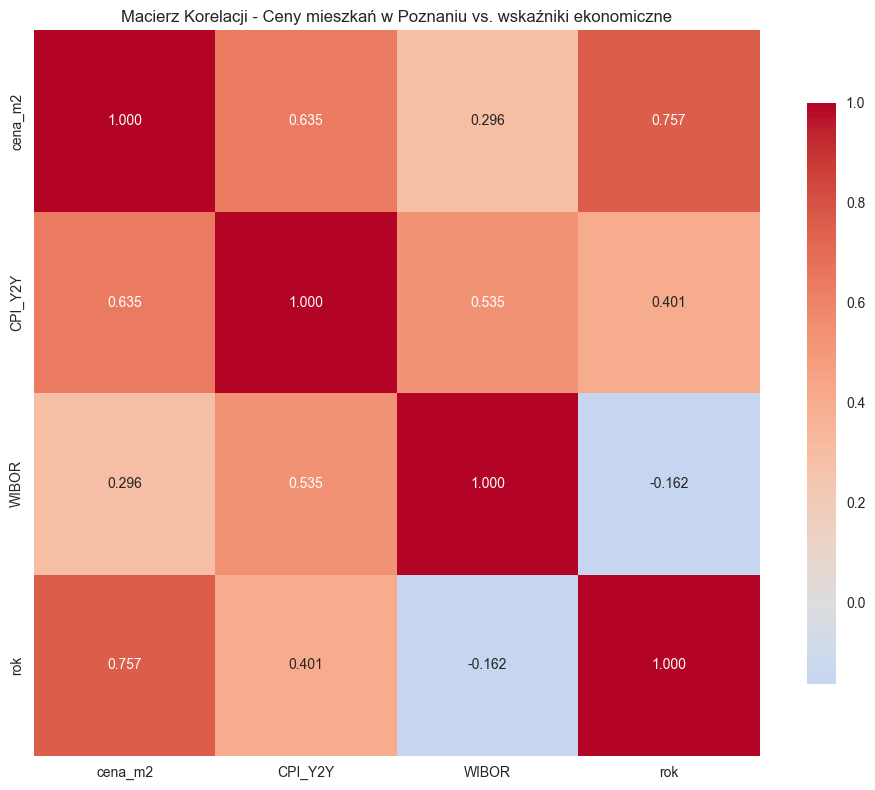

In [14]:
# Komórka 5: Analiza statystyczna dla danych w nowym formacie

def przeksztalc_dane_do_formatu_dlugiego():
    """
    Przekształca cztery dataframes z miastami jako kolumnami do formatu długiego
    """
    print("🔄 Przekształcanie danych do formatu długiego...")
    
    miasta = [
        'Białystok', 'Bydgoszcz', 'Gdańsk', 'Gdynia', 'Katowice', 'Kielce', 'Kraków', 'Lublin',
        'Łódź', 'Olsztyn', 'Opole', 'Poznań', 'Rzeszów', 'Szczecin', 'Warszawa', 'Wrocław', 'Zielona Góra'
    ]
    
    # Przekształcanie do formatu długiego
    def melt_cities(df, rynek, typ_ceny, miasta):
        # Identyfikuj kolumny niebędące miastami
        id_vars = ['Kwartał', 'Data', 'rok', 'kwartal_num', 'indeks_czasowy', 'CPI_Y2Y', 'CPI_Q2Q', 'WIBOR']
        # Upewnij się, że wszystkie kolumny id_vars istnieją w df
        id_vars = [col for col in id_vars if col in df.columns]
        
        # Przekształć do formatu długiego
        df_long = df.melt(
            id_vars=id_vars,
            value_vars=[miasto for miasto in miasta if miasto in df.columns],
            var_name='miasto',
            value_name='cena_m2'
        )
        
        # Dodaj informacje o rynku i typie ceny
        df_long['rynek'] = rynek
        df_long['typ_ceny'] = typ_ceny
        
        return df_long
    
    # Zastosuj do czterech dataframes
    df_pierw_of_long = melt_cities(rynek_pierwotny_ofertowe, 'pierwotny', 'ofertowa', miasta)
    df_pierw_tr_long = melt_cities(rynek_pierwotny_transakcyjne, 'pierwotny', 'transakcyjna', miasta)
    df_wtor_of_long = melt_cities(rynek_wtorny_ofertowe, 'wtórny', 'ofertowa', miasta)
    df_wtor_tr_long = melt_cities(rynek_wtorny_transakcyjne, 'wtórny', 'transakcyjna', miasta)
    
    # Połącz wszystkie dane w jeden DataFrame
    df_all = pd.concat([
        df_pierw_of_long, df_pierw_tr_long, df_wtor_of_long, df_wtor_tr_long
    ], ignore_index=True)
    
    print(f"✅ Dane przekształcone: {len(df_all):,} rekordów, {df_all['miasto'].nunique()} miast")
    return df_all

def sanityzacja_danych_long(df):
    """
    Oczyszcza dane w formacie długim i dodaje nowe cechy
    """
    print("🧹 Sanityzacja danych w formacie długim...")
    
    # Usuń rekordy z brakującymi cenami
    df = df.dropna(subset=['cena_m2'])
    print(f"📊 Po usunięciu rekordów z brakami: {len(df):,} rekordów")
    
    # Konwertuj ceny do typu float, jeśli nie są
    df['cena_m2'] = pd.to_numeric(df['cena_m2'], errors='coerce')
    df = df.dropna(subset=['cena_m2'])
    
    # Detekcja outlierów metodą IQR dla każdego miasta, rynku i typu ceny
    def process_group(group):
        if len(group) <= 5:  # Zbyt mało danych dla wiarygodnej detekcji outlierów
            return group
        
        Q1 = group['cena_m2'].quantile(0.25)
        Q3 = group['cena_m2'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Winsoryzacja (ograniczenie wartości skrajnych)
        group.loc[group['cena_m2'] < lower_bound, 'cena_m2'] = lower_bound
        group.loc[group['cena_m2'] > upper_bound, 'cena_m2'] = upper_bound
        
        return group
    
    # Zastosuj sanityzację do każdej grupy miasto-rynek-typ_ceny
    df = df.groupby(['miasto', 'rynek', 'typ_ceny']).apply(process_group).reset_index(drop=True)
    
    # Feature engineering
    df = df.sort_values(['miasto', 'rynek', 'typ_ceny', 'Data'])
    
    # Dodaj zmienne lagowane i rolling
    for miasto in df['miasto'].unique():
        for rynek in df['rynek'].unique():
            for typ in df['typ_ceny'].unique():
                mask = (df['miasto'] == miasto) & (df['rynek'] == rynek) & (df['typ_ceny'] == typ)
                
                # Lagowane wartości cen
                df.loc[mask, 'cena_lag1'] = df.loc[mask, 'cena_m2'].shift(1)
                df.loc[mask, 'cena_lag4'] = df.loc[mask, 'cena_m2'].shift(4)
                
                # Średnie kroczące
                df.loc[mask, 'cena_ma4'] = df.loc[mask, 'cena_m2'].rolling(4).mean().values
                
                # Zmiany rok do roku (YoY)
                df.loc[mask, 'cena_yoy'] = df.loc[mask, 'cena_m2'].pct_change(periods=4).values * 100
    
    # Ceny realne (skorygowane o inflację)
    if 'CPI_Y2Y' in df.columns:
        df['cena_realna'] = df['cena_m2'] / (df['CPI_Y2Y']/100)
    
    # Trendy kwadratowe
    df['rok_kwadrat'] = df['rok'] ** 2
    df['indeks_kwadrat'] = df['indeks_czasowy'] ** 2
    
    print(f"✅ Dane przetworzone. Dodano cechy lagowane, rolling i YoY")
    return df

def analiza_korelacji(df):
    """
    Przeprowadza analizę korelacji między cenami mieszkań a zmiennymi ekonomicznymi
    """
    print("🔗 Analiza korelacji...")
    
    # Przygotuj dane dla korelacji
    rezultaty_korelacji = {}
    
    for miasto in df['miasto'].unique():
        for rynek in df['rynek'].unique():
            for typ_ceny in df['typ_ceny'].unique():
                mask = (df['miasto'] == miasto) & (df['rynek'] == rynek) & (df['typ_ceny'] == typ_ceny)
                dane_segmentu = df[mask].dropna(subset=['cena_m2', 'CPI_Y2Y', 'WIBOR'])
                
                if len(dane_segmentu) >= 10:  # Minimum 10 obserwacji dla wiarygodnej korelacji
                    # Korelacja z inflacją
                    corr_inflacja, p_inflacja = pearsonr(dane_segmentu['cena_m2'].to_list(), dane_segmentu['CPI_Y2Y'].to_list())
                    
                    # Korelacja z WIBOR
                    corr_wibor, p_wibor = pearsonr(dane_segmentu['cena_m2'].to_list(), dane_segmentu['WIBOR'].to_list())
                    
                    klucz = f"{miasto}_{rynek}_{typ_ceny}"
                    rezultaty_korelacji[klucz] = {
                        'inflacja_corr': corr_inflacja,
                        'inflacja_p': p_inflacja,
                        'wibor_corr': corr_wibor,
                        'wibor_p': p_wibor
                    }
    
    # Pokaż wyniki dla wybranych miast
    for miasto in ['Poznań', 'Warszawa']:
        for rynek in df['rynek'].unique():
            for typ_ceny in df['typ_ceny'].unique():
                klucz = f"{miasto}_{rynek}_{typ_ceny}"
                if klucz in rezultaty_korelacji:
                    stats = rezultaty_korelacji[klucz]
                    print(f"\n{klucz}:")
                    print(f"  Inflacja CPI: r={stats['inflacja_corr']:.3f}, p={stats['inflacja_p']:.3f}")
                    print(f"  WIBOR: r={stats['wibor_corr']:.3f}, p={stats['wibor_p']:.3f}")
    
    # Wizualizacja korelacji dla Warszawy
    warsaw_data = df[df['miasto'] == 'Poznań']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_vars = ['cena_m2', 'CPI_Y2Y', 'WIBOR', 'rok']
    correlation_matrix = warsaw_data[corr_vars].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
               square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Macierz Korelacji - Ceny mieszkań w Poznaniu vs. wskaźniki ekonomiczne')
    plt.tight_layout()
    plt.show()
    
    return rezultaty_korelacji

# Wykonaj przekształcenie i analizę danych
df_mieszkania = przeksztalc_dane_do_formatu_dlugiego()
df_mieszkania_clean = sanityzacja_danych_long(df_mieszkania)

# Przeprowadź analizy statystyczne
korelacje = analiza_korelacji(df_mieszkania_clean)


## Komórka 7: Modele uczenia maszynowego dla danych w nowym formacie


In [16]:
# Komórka 7: Modele uczenia maszynowego dla danych w nowym formacie

def przygotuj_dane_do_modelowania(df, miasto_target='Warszawa'):
    """
    Przygotowuje dane do modelowania ML w formacie długim
    """
    print(f"🤖 Przygotowywanie danych do modelowania dla miasta {miasto_target}...")
    
    # Filtrujemy dane dla wybranego miasta i typu ceny (transakcyjne)
    dane_miasta = df[(df['miasto'] == miasto_target) & (df['typ_ceny'] == 'transakcyjna')].copy()
    
    # Sprawdzamy, czy mamy wystarczającą liczbę obserwacji
    if len(dane_miasta) < 20:
        print(f"⚠️ Zbyt mało danych dla miasta {miasto_target}: {len(dane_miasta)} obserwacji")
        print("Używamy minimum 20 obserwacji dla wiarygodnego modelowania")
        return None, None, None, None
    
    # Usuwamy rekordy z brakującymi wartościami w kluczowych kolumnach
    dane_miasta = dane_miasta.dropna(subset=['cena_m2', 'CPI_Y2Y', 'WIBOR'])
    
    # Kodowanie zmiennych kategorycznych
    le_rynek = LabelEncoder()
    dane_miasta['rynek_encoded'] = le_rynek.fit_transform(dane_miasta['rynek'])
    
    # Wybór cech do modelowania
    cechy = [
        'rok', 'kwartal_num', 'indeks_czasowy', 'CPI_Y2Y', 'WIBOR', 
        'rynek_encoded', 'rok_kwadrat'
    ]
    
    # Dodaj cechy lagowane jeśli dostępne
    for col in ['cena_lag1', 'cena_lag4', 'cena_ma4']:
        if col in dane_miasta.columns and dane_miasta[col].notna().sum() > len(dane_miasta) * 0.8:
            cechy.append(col)
    
    # Usuwamy rekordy z NaN w cechach
    dane_kompletne = dane_miasta.dropna(subset=cechy + ['cena_m2'])
    
    # Sortujemy dane według czasu
    dane_kompletne = dane_kompletne.sort_values('Data')
    
    X = dane_kompletne[cechy]
    y = dane_kompletne['cena_m2']
    
    print(f"📊 Przygotowano {len(X)} próbek z {len(cechy)} cechami")
    print(f"📋 Cechy: {cechy}")
    
    return X, y, dane_kompletne, le_rynek

def trenuj_modele_ml(X, y):
    """
    Trenuje różne modele ML i porównuje ich wydajność
    """
    if X is None or y is None:
        print("❌ Brak danych do trenowania modeli")
        return None, None, None, None
    
    print("🏋️ Trenowanie modeli uczenia maszynowego...")
    
    # Podział danych (uwaga na kolejność czasową)
    n_train = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
    y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
    
    print(f"📊 Dane treningowe: {len(X_train)} próbek, testowe: {len(X_test)} próbek")
    
    # Skalowanie cech
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Słownik modeli
    modele = {
        'Linear Regression': LinearRegression()
    }
    
    # Trenowanie i ewaluacja modeli
    wyniki_modeli = {}
    
    for nazwa_modelu, model in modele.items():
        print(f"🔧 Trenowanie {nazwa_modelu}...")
        
        if nazwa_modelu == 'Linear Regression':
            # Użyj skalowanych danych dla regresji liniowej
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            # Użyj oryginalnych danych dla modeli drzewiastych
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Oblicz metryki
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Oblicz błąd względny (MAPE)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        wyniki_modeli[nazwa_modelu] = {
            'model': model,
            'predictions': y_pred,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        }
        
        print(f"✅ {nazwa_modelu} - R²: {r2:.4f}, RMSE: {rmse:.0f}, MAE: {mae:.0f}, MAPE: {mape:.2f}%")
    
    return wyniki_modeli, X_test, y_test, scaler

def wizualizacja_porownania_modeli(wyniki_modeli, X_test, y_test, miasto='Warszawa'):
    """
    Tworzy wizualizację porównania modeli
    """
    if wyniki_modeli is None:
        print("❌ Brak wyników modeli do wizualizacji")
        return None
    
    print("📊 Tworzenie wizualizacji porównania modeli...")
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Porównanie Predykcji vs Rzeczywiste',
            'Metryki Wydajności Modeli',
            'Błędy Predykcji (Residuals)',
            'Ważność Cech (Random Forest)'
        )
    )
    
    kolory_modeli = ['blue', 'green', 'red']
    
    # 1. Predykcje vs rzeczywiste wartości
    for i, (nazwa, wyniki) in enumerate(wyniki_modeli.items()):
        fig.add_trace(
            go.Scatter(
                x=y_test,
                y=wyniki['predictions'],
                mode='markers',
                name=nazwa,
                marker=dict(color=kolory_modeli[i], size=6, opacity=0.7)
            ),
            row=1, col=1
        )
    
    # Dodaj linię idealną
    min_val, max_val = y_test.min(), y_test.max()
    buffer = (max_val - min_val) * 0.1
    fig.add_trace(
        go.Scatter(
            x=[min_val - buffer, max_val + buffer],
            y=[min_val - buffer, max_val + buffer],
            mode='lines',
            name='Idealna predykcja',
            line=dict(dash='dash', color='gray'),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. Metryki wydajności
    metryki = ['R²', 'RMSE', 'MAE', 'MAPE']
    nazwy_modeli = list(wyniki_modeli.keys())
    
    for i, metryka in enumerate(['r2', 'rmse', 'mae', 'mape']):
        wartosci = [wyniki_modeli[model][metryka] for model in nazwy_modeli]
        fig.add_trace(
            go.Bar(
                x=nazwy_modeli,
                y=wartosci,
                name=metryki[i],
                showlegend=True
            ),
            row=1, col=2
        )
    
    # 3. Rozkład błędów
    for i, (nazwa, wyniki) in enumerate(wyniki_modeli.items()):
        bledy = y_test - wyniki['predictions']
        fig.add_trace(
            go.Box(
                y=bledy,
                name=nazwa,
                marker_color=kolory_modeli[i],
                showlegend=False
            ),
            row=2, col=1
        )
    
    # 4. Ważność cech (tylko dla Random Forest)
    if 'Random Forest' in wyniki_modeli:
        rf_model = wyniki_modeli['Random Forest']['model']
        waznosci = rf_model.feature_importances_
        nazwy_cech = X_test.columns
        
        # Sortuj według ważności
        cecha_waznosc = list(zip(nazwy_cech, waznosci))
        cecha_waznosc.sort(key=lambda x: x[1], reverse=True)
        
        fig.add_trace(
            go.Bar(
                x=[w for _, w in cecha_waznosc],
                y=[c for c, _ in cecha_waznosc],
                orientation='h',
                marker_color='lightgreen',
                showlegend=False
            ),
            row=2, col=2
        )
    
    # Aktualizacja layoutu
    fig.update_layout(
        height=800,
        title_text=f"Porównanie Modeli Predykcyjnych - Ceny Mieszkań w {miasto}",
        title_x=0.5,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )
    
    # Aktualizacja etykiet osi
    fig.update_xaxes(title_text="Rzeczywiste ceny (PLN/m²)", row=1, col=1)
    fig.update_yaxes(title_text="Predykcje (PLN/m²)", row=1, col=1)
    
    fig.update_xaxes(title_text="Model", row=1, col=2)
    fig.update_yaxes(title_text="Wartość metryki", row=1, col=2)
    
    fig.update_xaxes(title_text="Model", row=2, col=1)
    fig.update_yaxes(title_text="Błąd predykcji (PLN/m²)", row=2, col=1)
    
    fig.update_xaxes(title_text="Ważność", row=2, col=2)
    fig.update_yaxes(title_text="Cecha", row=2, col=2)
    
    return fig

# Zdefiniuj listę miast do analizy
miasta_do_analizy = ['Warszawa', 'Kraków', 'Wrocław']

# Trenowanie modeli i tworzenie prognoz dla wybranych miast
for miasto in miasta_do_analizy:
    print(f"\n{'='*50}")
    print(f"ANALIZA DLA MIASTA: {miasto}")
    print(f"{'='*50}")
    
    # Przygotuj dane
    X, y, dane_kompletne, le_rynek = przygotuj_dane_do_modelowania(df_mieszkania_clean, miasto_target=miasto)
    
    if X is not None and y is not None:
        # Trenuj modele
        wyniki_modeli, X_test, y_test, scaler = trenuj_modele_ml(X, y)
        
        if wyniki_modeli is not None:
            # Wizualizacja porównania modeli
            wykres_modeli = wizualizacja_porownania_modeli(wyniki_modeli, X_test, y_test, miasto=miasto)
            wykres_modeli.show()
            
            # Podsumowanie wyników
            print(f"\n🏆 PODSUMOWANIE WYDAJNOŚCI MODELI dla {miasto}:")
            print("="*60)
            for nazwa, wyniki in wyniki_modeli.items():
                print(f"{nazwa:20} | R²: {wyniki['r2']:6.4f} | RMSE: {wyniki['rmse']:7.0f} | MAE: {wyniki['mae']:6.0f} | MAPE: {wyniki['mape']:5.2f}%")



ANALIZA DLA MIASTA: Warszawa
🤖 Przygotowywanie danych do modelowania dla miasta Warszawa...
📊 Przygotowano 142 próbek z 10 cechami
📋 Cechy: ['rok', 'kwartal_num', 'indeks_czasowy', 'CPI_Y2Y', 'WIBOR', 'rynek_encoded', 'rok_kwadrat', 'cena_lag1', 'cena_lag4', 'cena_ma4']
🏋️ Trenowanie modeli uczenia maszynowego...
📊 Dane treningowe: 113 próbek, testowe: 29 próbek
🔧 Trenowanie Linear Regression...
✅ Linear Regression - R²: 0.8666, RMSE: 362, MAE: 281, MAPE: 2.10%
📊 Tworzenie wizualizacji porównania modeli...



🏆 PODSUMOWANIE WYDAJNOŚCI MODELI dla Warszawa:
Linear Regression    | R²: 0.8666 | RMSE:     362 | MAE:    281 | MAPE:  2.10%

ANALIZA DLA MIASTA: Kraków
🤖 Przygotowywanie danych do modelowania dla miasta Kraków...
📊 Przygotowano 142 próbek z 10 cechami
📋 Cechy: ['rok', 'kwartal_num', 'indeks_czasowy', 'CPI_Y2Y', 'WIBOR', 'rynek_encoded', 'rok_kwadrat', 'cena_lag1', 'cena_lag4', 'cena_ma4']
🏋️ Trenowanie modeli uczenia maszynowego...
📊 Dane treningowe: 113 próbek, testowe: 29 próbek
🔧 Trenowanie Linear Regression...
✅ Linear Regression - R²: 0.8838, RMSE: 244, MAE: 186, MAPE: 1.60%
📊 Tworzenie wizualizacji porównania modeli...



🏆 PODSUMOWANIE WYDAJNOŚCI MODELI dla Kraków:
Linear Regression    | R²: 0.8838 | RMSE:     244 | MAE:    186 | MAPE:  1.60%

ANALIZA DLA MIASTA: Wrocław
🤖 Przygotowywanie danych do modelowania dla miasta Wrocław...
📊 Przygotowano 142 próbek z 10 cechami
📋 Cechy: ['rok', 'kwartal_num', 'indeks_czasowy', 'CPI_Y2Y', 'WIBOR', 'rynek_encoded', 'rok_kwadrat', 'cena_lag1', 'cena_lag4', 'cena_ma4']
🏋️ Trenowanie modeli uczenia maszynowego...
📊 Dane treningowe: 113 próbek, testowe: 29 próbek
🔧 Trenowanie Linear Regression...
✅ Linear Regression - R²: 0.9096, RMSE: 275, MAE: 243, MAPE: 2.28%
📊 Tworzenie wizualizacji porównania modeli...



🏆 PODSUMOWANIE WYDAJNOŚCI MODELI dla Wrocław:
Linear Regression    | R²: 0.9096 | RMSE:     275 | MAE:    243 | MAPE:  2.28%
